In [1]:
import cv2 as cv
import numpy as np
import seaborn as sns

font = cv.FONT_HERSHEY_SIMPLEX
org = (50, 50)
fontScale = 1
color = (255, 255, 255)
thickness = 2

kernel = np.ones((3,3),np.uint8)


In [2]:
def compute_lines(line: np.array):
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 480*(-b))
    y1 = int(y0 + 600*(a))
    x2 = int(x0 - 480*(-b))
    y2 = int(y0 - 600*(a))
    return x1, y1, x2, y2

In [3]:
def calibrate_threshold(cap: cv.VideoCapture) -> int:
    calibrating = True
    threshold = 127
    
    while calibrating:
        ret, frame = cap.read()
        # if frame is read correctly ret is True
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break

        imgray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        _, thresh = cv.threshold(imgray, threshold, 100, cv.THRESH_BINARY)

        pressed_key = cv.waitKey(1)
        if pressed_key == ord('a'):
            threshold = min(255, threshold + 10)
        elif pressed_key == ord('s'):
            print('hey')
            threshold = max(0, threshold - 10)
        elif pressed_key == ord(' '):
            calibrating = False

        thresh = cv.putText(
            thresh, str(threshold), org, font, 
                   fontScale, (255, 255, 255), thickness, cv.LINE_AA)
        # print(threshold)
        cv.imshow('frame', thresh)

    return threshold

In [4]:
def calibrate_camera(cap: cv.VideoCapture, threshold: int) -> np.array:
    calibrating = True

    width = cap.get(cv.CAP_PROP_FRAME_WIDTH)
    height = cap.get(cv.CAP_PROP_FRAME_HEIGHT)

    cl_x1 = int(width/2)
    cl_y1 = 0
    cl_x2 = int(width/2)
    cl_y2 = int(height)
    central_line = np.array([cl_x1, cl_y1, cl_x2, cl_y2])


    n_votes = 350
    
    while calibrating:
        ret, frame = cap.read()
        # if frame is read correctly ret is True
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break
                
        imgray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        ret, thresh = cv.threshold(imgray, threshold, 100, cv.THRESH_BINARY)
        edges = cv.Canny(thresh,50,150, apertureSize = 3)
        edges = cv.dilate(edges,kernel,iterations = 1)

        pressed_key = cv.waitKey(1)
        if pressed_key == ord('a'):
            n_votes = min(1000, n_votes + 10)
        elif pressed_key == ord('s'):
            n_votes = max(0, n_votes - 10)
        elif pressed_key == ord(' '):
            calibrating = False


        lines = cv.HoughLines(
            edges, 
            1,  
            np.pi/180, 
            n_votes, 
            # minLineLength=300, 
            # maxLineGap=30
        )

        right_line = None
        right_line_lenght = 0
        left_line = None
        left_line_lenght = 0
        try:
            for line in lines:
                x1,y1,x2,y2 = compute_lines(line)
                cv.line(frame,(x1, y1),(x2, y2),(0,0, 255),2)
                
            #     x1_diff = cl_x1 - x1
            #     y1_diff = cl_y1 - y1
            #     x2_diff = cl_x2 - x2
            #     y2_diff = cl_y2 - y2
            #     line_lenght = (x2 - x1) ** 2 + (y2 - y1) ** 2
            #     if x1_diff > 0 and x2_diff > 0:
            #         if line_lenght > right_line_lenght:
            #             right_line = line[0]
            #     elif x1_diff < 0 and x2_diff < 0:
            #         if line_lenght > left_line_lenght:
            #             left_line = line[0]
                        
            # cv.line(frame,(left_line[0],left_line[1]),(left_line[2],left_line[3]),(0,0, 255),2)
            # cv.line(frame,(right_line[0],right_line[1]),(right_line[2],right_line[3]),(0,255,0),2)
            cv.line(frame,(cl_x1, cl_y1), (cl_x2, cl_y2),(255,255,255),2)
        except TypeError as e:
            print(f'Nao foi possivel identificar linhas: {e}')
            
        # dest = cv.cornerHarris(thresh, 2, 5, 0.03)
        # dest = cv.dilate(dest, None) 
        # frame[dest > 0.01 * dest.max()]=[0, 0, 255]

        frame = cv.putText(
            frame, str(n_votes), org, font, 
                   fontScale, (255, 255, 255), thickness, cv.LINE_AA)
        cv.imshow('frame', frame)

    return lines, n_votes

In [43]:
cap = cv.VideoCapture(0)
if not cap.isOpened():
    print("Cannot open camera")
    exit()

main_loop = True

threshold = calibrate_threshold(cap)
# threshold = 177
calibrated_lines, n_votes = calibrate_camera(cap, threshold)


ret, frame = cap.read()
imgray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgray, threshold, 255, cv.THRESH_BINARY)
belt_histogram = np.sum(255 - thresh, axis=0)
belt_histogram = belt_histogram / np.max(belt_histogram)
left_belt = belt_histogram[:320]
right_belt = belt_histogram[320:]

TOLERANCE = 1

image_series = np.array([thresh] * 10)

belt_diff_series = [0] * 50
window_median_series = []

while main_loop:
    ret, frame = cap.read()

    imgray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(imgray, threshold, 255, cv.THRESH_BINARY_INV)
    # inverse = cv.copyMakeBorder(inverse, 10, 10, 10, 10, cv.BORDER_CONSTANT, None, (0, 0, 0))
    processed_image = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
    processed_image = cv.morphologyEx(processed_image, cv.MORPH_DILATE, kernel, iterations=3)

    image_series[:-1] = image_series[1:]
    image_series[-1] = processed_image


    edges = cv.Canny(thresh,50,150)
    edges = cv.dilate(edges,kernel,iterations = 1)

    print(np.median(image_series, axis=0).shape)
    image_median = np.median(image_series, axis=0).astype("uint8")
    image_median = cv.medianBlur(image_median, 9)

    
    try:
        contours,hierarchy = cv.findContours(image_median, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        # cnt = contours[4]
        # cv.drawContours(frame, [cnt], 0, (0,255,0), 3)
        cv.drawContours(frame, contours, 0, (0,255,0), 2)
    except:
        print('nenhum contorno')

    live_belt_histogram = np.sum(255 - thresh, axis=0)
    live_belt_histogram = live_belt_histogram / np.max(live_belt_histogram)
    # live_left_belt = belt_histogram[:320]
    # live_right_belt = belt_histogram[320:]

    # left_diff = np.sum(live_left_belt - left_belt)
    # right_diff = np.sum(live_right_belt - right_belt)

    belt_diff = np.sum(live_belt_histogram - belt_histogram)
    belt_diff_series.append(belt_diff)
    median_window = np.median(belt_diff_series[-50:])
    window_median_series.append(median_window)

    if median_window > TOLERANCE:
        actor_response = 'Esquerda'
    elif median_window < -TOLERANCE: 
        actor_response = 'Direita'
    else:
        actor_response = ' '


    frame = cv.putText(
            frame, str(np.round(belt_diff, 2)), org, font, 
                   fontScale, (0, 0, 0), thickness, cv.LINE_AA)
    frame = cv.putText(
            frame, str(np.round(median_window, 2)), (50, 100), font, 
                   fontScale, (0, 0, 0), thickness, cv.LINE_AA)
    frame = cv.putText(
            frame, actor_response, (50, 150), font, 
                   fontScale, (0, 0, 0), thickness, cv.LINE_AA)


    lines = cv.HoughLines(edges, 1, np.pi/180, n_votes)

    try:
        for line in lines:
            x1, y1, x2, y2 = compute_lines(line)
            cv.line(frame,(x1,y1),(x2,y2),(0,0,255),2)

        for line in calibrated_lines:
            x1, y1, x2, y2 = compute_lines(line)
            cv.line(frame,(x1,y1),(x2,y2),(0,255,0),2)

    except TypeError as e:
        print('Nao foi possivel identificar linhas')
    
    cv.imshow('frame', frame)

    if cv.waitKey(1) == ord('q'):
        main_loop = False
 
# When everything done, release the capture
cap.release()
cv.destroyAllWindows()

hey
hey
hey
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640

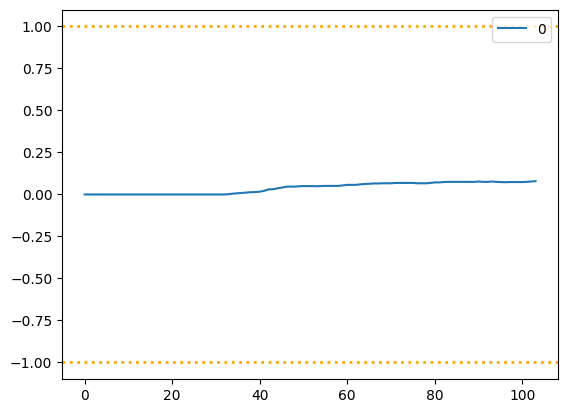

In [6]:
ax = sns.lineplot(
    [
        # belt_diff_series[50:],
        window_median_series
    ], 
    markers=False
)
ax.axhline(y=TOLERANCE, linewidth=2, color='orange', ls=':')
ax.axhline(y=-TOLERANCE, linewidth=2, color='orange', ls=':')

<Axes: >

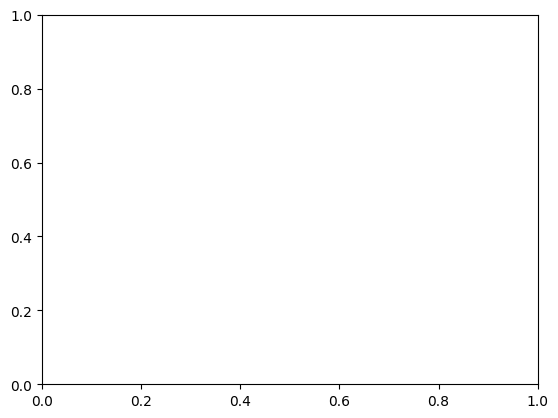

In [7]:
sns.lineplot()

<Axes: >

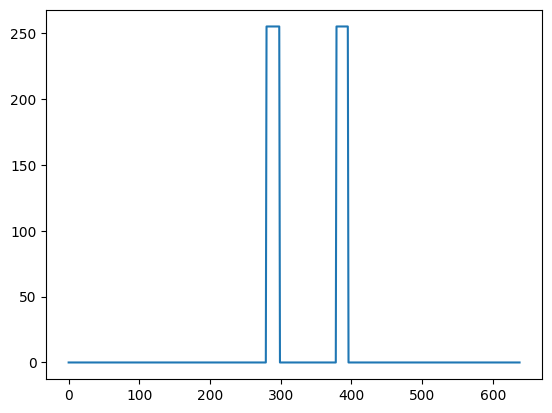

In [8]:
arr = np.diff(np.sum(255 - thresh, axis=0))
arr[arr > 255] = 255
sns.lineplot(arr)

<Axes: >

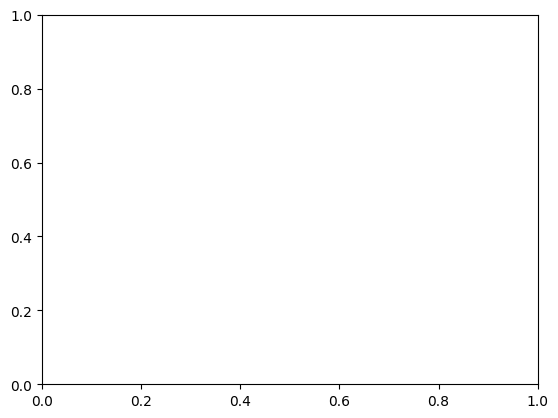

In [9]:
sns.lineplot()

In [10]:
ret, frame = cap.read()
edges = cv.Canny(frame, 200,150)

In [11]:
plt.imshow(edges)

NameError: name 'plt' is not defined

In [ ]:
lines = cv.HoughLines(edges,2, np.pi/180,260)

try:
    for line in lines:
        rho,theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv.line(frame,(x1,y1),(x2,y2),(0,0,255),2)

except TypeError as e:
    print('Nao foi possivel identificar linhas')

In [ ]:
imgray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

In [ ]:
cv.drawContours(frame, contours, -1, (0,255,0), 3)

array([[[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       ...,

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

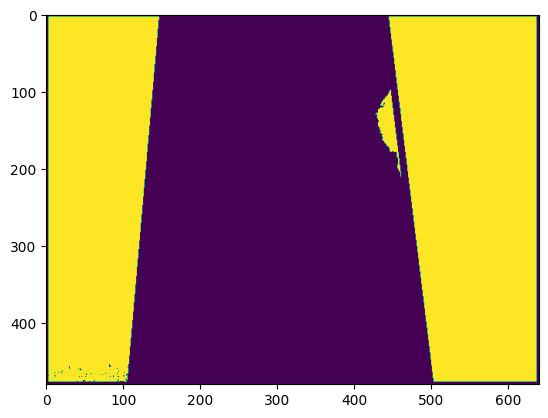

In [ ]:
imgray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgray, 180, 200, 0)
plt.imshow(thresh)

In [ ]:

    
    ret, frame = cap.read()
 
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    edges = cv.Canny(frame,100,200)
    # Our operations on the frame come here
    # gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    # Display the resulting frame

    lines = cv.HoughLines(edges,2, np.pi/180,260)

    try:
        for line in lines:
            rho,theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))

            cv.line(frame,(x1,y1),(x2,y2),(0,0,255),2)

    except TypeError as e:
        print('Nao foi possivel identificar linhas')

    cv.imshow('frame', frame)
    if cv.waitKey(1) == ord('q'):
        break
 
# When everything done, release the capture
cap.release()
cv.destroyAllWindows()